# Анализ изменения цены лечения в медицинской клинике в 2022 году относительно 2021 года

### Цель проекта: определить ключевые драйверы изменения цены лечения


### Описание данных:
- record_id - уникальный идентификатор строки данных
- service_data - дата оказания медицинской услуги
- service_name - наименование медицинской услуги
- service_nambe - количество услуг
- service_amount - сумма выплат (стоимость оказанных услуг в рублях)
- insured - уникальный идентификатор пациента
- sex_id - пол пациента
- age_for_service_date - возраст пациента

## Загрузка, предобработка и базовый анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# загрузим данные
df = pd.read_excel('data_test_task_2022.xlsx') 

In [4]:
# посмотрим на данные
df.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26


In [5]:
# получим общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


Пропущено очень небольшое количество данных в столбце sex_id, что представляется несущественным замечанием не влияющим на результаты исследования.
Необходимо изменить тип данных в столбце service_date на дату.

In [6]:
# выделим номера клиентов, у которых есть пропуск в поле пола:
missing_id = df.query('sex_id != sex_id')['insured'].unique()

# посмотрим, а есть ли такие записи для этих клиентов без пропусков:
df.query('sex_id == sex_id and insured in @missing_id')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
29311,31408954403,2021-09-24,Прием первичный,1470,1,512590,2.0,27
29312,31408954503,2021-09-25,Рентгенография крупного сустава (2 снимка),1575,1,512590,2.0,27
29313,31408954603,2021-09-25,Ультразвуковое исследование сустава,1890,1,512590,2.0,27
29314,31408954703,2021-09-27,Прием повторный,1313,1,512590,2.0,27


Выше видно, что для одного клиента мы можем заменить пропуски - для него есть информация о принадлежности к полу.

In [7]:
# заполним пропуски
display(df['sex_id'].isna().sum())
df['sex_id'].fillna(df.groupby(['insured'])['sex_id'].transform('first'), inplace=True)
display(df['sex_id'].isna().sum())

21

4

Пропуски остались только в 4 записях

In [8]:
df['service_date'] = pd.to_datetime(df['service_date']) # изменим тип данных на дату

In [9]:
df['service_date'].dtype # проверим преобразование

dtype('<M8[ns]')

In [10]:
df.duplicated().sum() # посчитаем количество явных дубликатов

0

Проверим не только полные, но и неявные дубликаты. Например, в нашем случае можно проверить дублирование записей посещения одного клиента, одного и того же врача, но с разницей в номере регистрации записи (`record_id`):

In [11]:
# найдём дублирование записей посещения одного клиента, одного и того же врача, но с разницей в номере регистрации записи
tmp = df[df.duplicated(subset=['service_date', 'service_name', 'service_amount',
                         'service_number', 'insured', 'sex_id', 'age_for_service_date'],
                 keep=False)]
tmp

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
49,30268161903,2021-01-05,Прием первичный,1470,1,418179,1.0,40
90,30268166003,2021-01-05,Прием повторный,1313,1,402409,2.0,36
93,30268166303,2021-01-05,Прием повторный,1313,1,402409,2.0,36
104,30268167403,2021-01-05,Прием первичный,1470,1,418179,1.0,40
142,30268171203,2021-01-21,Прием повторный,1313,1,166120,2.0,33
...,...,...,...,...,...,...,...,...
81340,32979021003,2022-07-12,Взятие крови из периферической вены,187,1,629910,2.0,40
83240,33177757303,2022-08-01,Исследование отделяемого молочной железы,1000,1,1302956,2.0,39
83241,33177757403,2022-08-01,Исследование отделяемого молочной железы,1000,1,1302956,2.0,39
85246,33178128603,2022-08-28,"В,мышечная инъекция (за 1 процедуру без стоимо...",320,1,1302824,2.0,39


Как видно таких записей много. Посмотрим на уникальные значения по услугам

In [12]:
# уникальные значения по услугам
tmp.groupby('service_name').agg({'insured':'nunique'}).sort_values(by='insured', ascending=False)

,insured
service_name,
Прием первичный,582
Прием повторный,213
Исследование отделяемого молочной железы,13
Рентгенография крупного сустава (2 снимка),12
Взятие мазка,8
Ультразвуковое исследование сустава,8
Взятие крови из периферической вены,8
"Сеанс SIS терапии, длинный цикл, 1 зона",3
"В,мышечная инъекция (за 1 процедуру без стоимости лекарств)",3


Как видно большинство записей - первичный или вторичный прием. Это связано с тем, что первичный или вторичный прием ведут разные врачи, а запись одинаковая. Т.е. у одного пациента в один день могут быть несколько первичных и/или вторичных приёмов у разных врачей (а в 2022 году систему поменяли и разделили первичные и вторичные приёмы по специалистам). Другие записи встречены в единичном количестве. 

In [13]:
# проверим наличие неявных дубликатов в столбце service_name
# посчитаем количество уникальных записей, переведем строки в нижний регистр и еще раз посчитаем количество уникальных записей
len(df['service_name'].sort_values().unique())

875

In [14]:
# переведём строки в нижний регистр и удалим пробелы в начале и конце строки
df['service_name'] = df['service_name'].str.strip().str.lower()

In [15]:
# неявных дублей связанных с регистром не обнаружено
len(df['service_name'].sort_values().unique())

875

Проверим наличие аномальных данных.

In [16]:
# посмотрим на описательную статистику
df['service_amount'].describe()

count    85369.000000
mean      1166.094636
std        799.062660
min        147.000000
25%        550.000000
50%       1155.000000
75%       1530.000000
max      26999.000000
Name: service_amount, dtype: float64

In [17]:
# выберем тему seaborn
sns.set_theme()

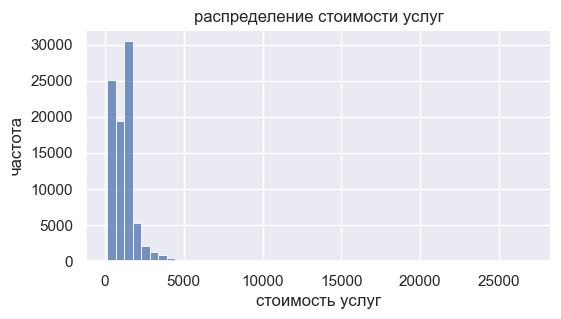

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(data=df, x='service_amount', bins=50)
ax.set(title = 'распределение стоимости услуг', xlabel = 'стоимость услуг', ylabel = 'частота')
plt.grid(True);

Распределение стоимости услуг ближе к распределению Пуассона

In [19]:
# посмотрим на самые дорогие услуги
df[df['service_amount'] >= 10_000].sort_values(by ='service_amount', ascending=False )

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
18519,30961787103,2021-06-24,"гистерорезектоскопия при полипах , рдв",26999,1,362928,2.0,51
15588,30961493203,2021-06-17,мрт брюшной полости и забрюшинного пространств...,17325,1,634755,1.0,41
23794,31249334503,2021-08-20,мрт головного мозга и гипофиза с контрастирова...,15225,1,544627,2.0,34
27994,31408821503,2021-09-09,мультипараметрическая мрт предстательной желез...,14175,1,531654,1.0,59
37286,31680697303,2021-11-10,мрт органов малого таза с внутривенным контрас...,13780,1,596539,2.0,27
83450,33177813203,2022-08-26,мрт коленного сустава,13000,2,1306792,2.0,27
16564,30961590803,2021-06-06,вскрытие абсцесса различной локализации,12810,2,181718,2.0,34
36348,31680600903,2021-11-07,мскт органов брюшной полости и забрюшинного пр...,12680,1,716141,2.0,31
36760,31680642403,2021-11-20,мскт органов брюшной полости и забрюшинного пр...,12680,1,743829,1.0,42
16373,30961571703,2021-06-06,мскт мочевыделительной системы с внутривенным ...,12075,1,634765,1.0,42


Данные по цене услуг представляются достоверными.

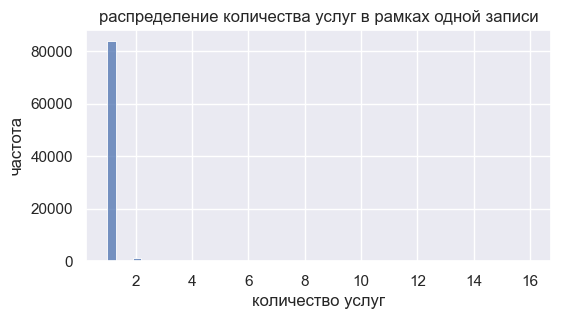

In [20]:
# посмотрим на распределение количества услуг в рамках одной записи
fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(data=df, x='service_number', bins=50)
ax.set(title = 'распределение количества услуг в рамках одной записи', xlabel = 'количество услуг', ylabel = 'частота')
plt.grid(True);

Чаще всего пациенты получают одну услугу

In [21]:
# таблица распределения количества услуг
df['service_number'].value_counts()

service_number
1     83807
2      1373
3       135
4        26
5        10
13        5
7         4
12        2
16        2
14        2
11        1
6         1
15        1
Name: count, dtype: int64

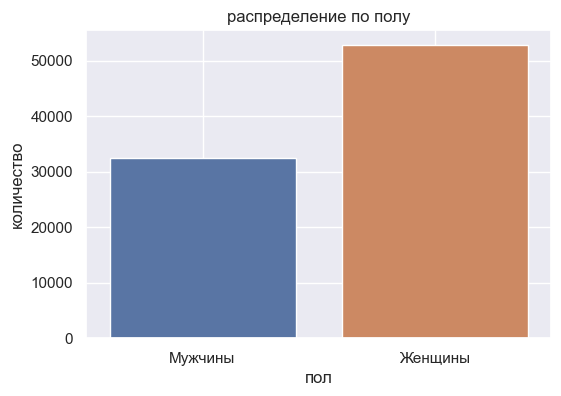

In [22]:
# посмотрим на распределение данных по полу
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(data=df, x='sex_id')
ax.set(title = 'распределение по полу', xlabel = 'пол', ylabel = 'количество')
ax.set_xticklabels(['Мужчины', 'Женщины'])
plt.grid(True);

Среди пациентов клиники женщин существенно больше, чем мужчин.

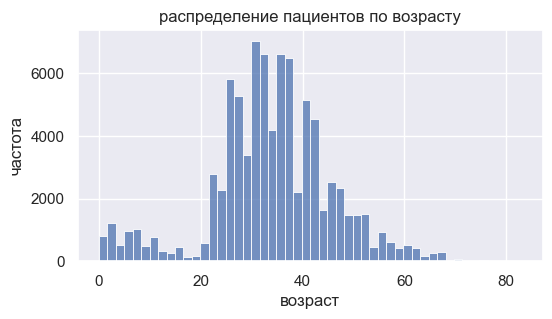

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(data=df, x='age_for_service_date', bins=50)
ax.set(title = 'распределение пациентов по возрасту', xlabel = 'возраст', ylabel = 'частота')
plt.grid(True);

Скорее всего возрат пациентов учитывали по числу полных лет, этим можно обьяснить возраст 0.

Аномальных данных в датасете не видно.

In [24]:
# посмотрим на временной промежуток, который охватывают данные
df['service_date'].min(), df['service_date'].max()

(Timestamp('2021-01-03 00:00:00'), Timestamp('2022-08-31 00:00:00'))

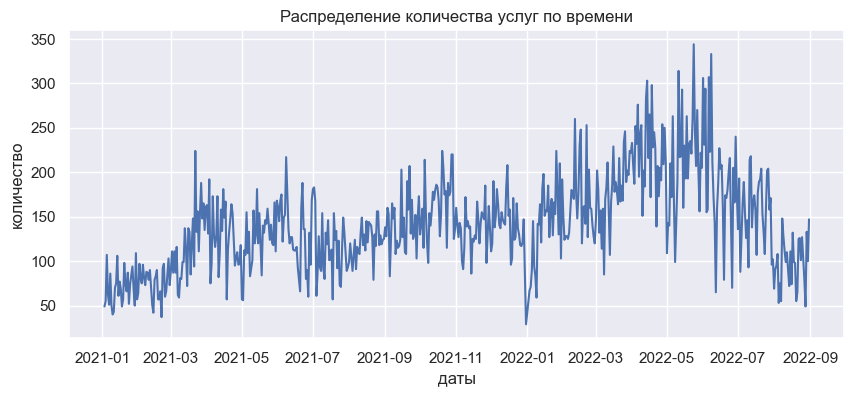

In [25]:
# Распределение количества услуг по времени
pivot = df.pivot_table(index='service_date', values='service_name', aggfunc='count').reset_index()

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=pivot,  x='service_date', y='service_name')
ax.set(title = 'Распределение количества услуг по времени', xlabel = 'даты', ylabel = 'количество')
plt.grid(True);

### Выводы по предобработке данных
В результате предобоработки данных было сделано следующее.
- обнаружено небольшое количество пропусков (всего 21) в столбце `sex_id`, было заполнено 17 данных по имеющимся сведениям в других записях;
- изменен тип данных в столбце `service_date` на дату;
- дубликатов не было обнаружено;
- построены распределения данных, аномалий не было обнаружено.

## Исследовательский анализ данных

### Выручка клиники и оценка изменений

In [26]:
# выделим из даты год и месяц и добавим такой столбец
df['year_month'] = df['service_date'].dt.to_period("M")

In [27]:
# выручка клиники по месяцам
revenue = df.groupby('year_month')['service_amount'].sum()

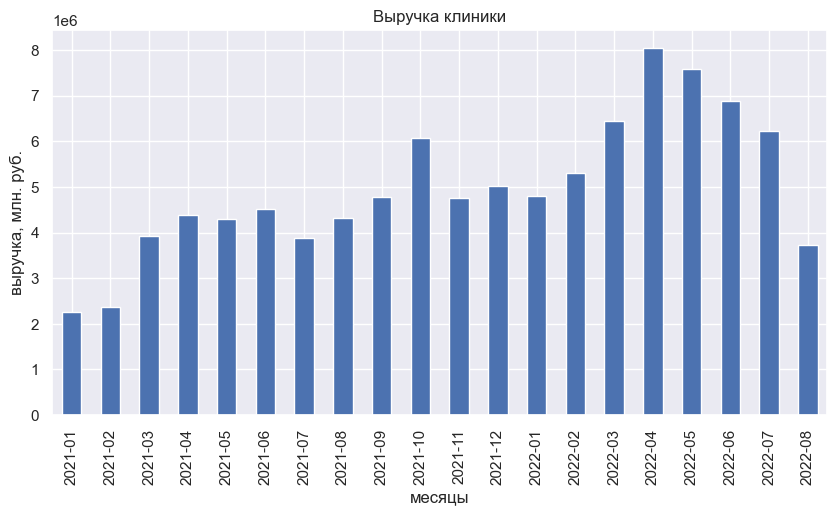

In [28]:
# график выручки
fig, ax = plt.subplots(figsize=(10, 5))
revenue.plot.bar(grid=True)
ax.set(title = 'Выручка клиники',
       xlabel = 'месяцы', ylabel = 'выручка, млн. руб.');

In [29]:
# выручка клиники за 8 месяцев 2021 года
revenue['2021-01' : '2021-08'].sum()

29957552

In [30]:
# выручка клиники за 8 месяцев 2022 года
revenue['2022-01' : '2022-08'].sum()

48986662

In [31]:
# Увеличение выручки клиники год к году (за 8 месяцев) в процентах
(revenue['2022-01' : '2022-08'].sum() / revenue['2021-01' : '2021-08'].sum() - 1) * 100

63.52024357664472

In [32]:
# найдем как менялась выручка год к году помесячно (январь к январю, февраль к февралю и т.д.), в процентах
(revenue['2022-01' : '2022-08'].reset_index()['service_amount'] /
revenue['2021-01' : '2021-08'].reset_index()['service_amount'] -1) * 100

0    111.847581
1    122.696790
2     64.264136
3     83.428920
4     76.509626
5     52.116102
6     60.541386
7    -13.760416
Name: service_amount, dtype: float64

Мы видим, что выручка в 2022 году (с января по июль) превышала выручку 2021 года по месяцам в пределах от 123% (в феврале) до 52% (в июне). При этом рост выручки замедлялся (от января к июлю), а в августе 2022 года выручка резко упала, что нельзя обьяснить сезонным фактором и случайными причинами, и что явно выбивается из динамики выручки.

Дадим определение тому, что мы будем понимать под "Средней стоимостью обслуживания пациентов".
Это будет отношение выручки клиники за период к количеству визитов за этот период (средний чек клиента или визита).


Визитом будем считать уникальное сочетание даты и идентификатора пациента (определение из технического задания). Если пациент был в клинике в 1 день несколько раз, то это 1 визит, а если был, например, 2 раза в разные дни, то это 2 визита.

In [33]:
# количество визитов в день
visits = df.groupby('service_date')['insured'].nunique().reset_index()
visits.head()

,service_date,insured
0,2021-01-03,12
1,2021-01-04,19
2,2021-01-05,28
3,2021-01-06,23
4,2021-01-07,20


In [34]:
# выделим из даты год и месяц и добавим такой столбец
visits['year_month'] = visits['service_date'].dt.to_period("M")

In [35]:
visits.head()

,service_date,insured,year_month
0,2021-01-03,12,2021-01
1,2021-01-04,19,2021-01
2,2021-01-05,28,2021-01
3,2021-01-06,23,2021-01
4,2021-01-07,20,2021-01


In [36]:
# количество визитов в месяц
visits_month = visits.groupby('year_month')['insured'].sum()
visits_month.head()

year_month
2021-01     743
2021-02     803
2021-03    1180
2021-04    1423
2021-05    1329
Freq: M, Name: insured, dtype: int64

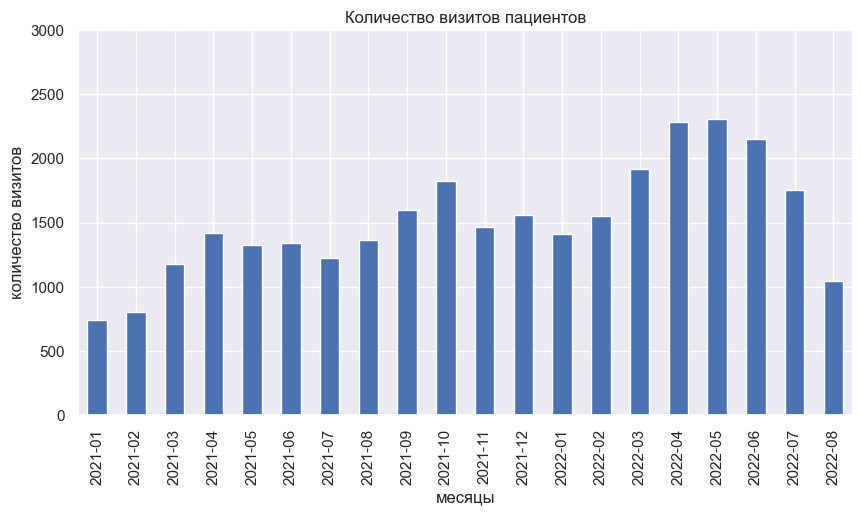

In [37]:
# построим график зависимости визитов пациентов от времени по месяцам
fig, ax = plt.subplots(figsize=(10, 5))
visits_month.plot.bar(ylim=(0, 3000), grid=True)
ax.set(title = 'Количество визитов пациентов', xlabel = 'месяцы', ylabel = 'количество визитов');

In [38]:
# сумма визитов за январь - август 2021 года
visits_month['2021-01' : '2021-08'].sum()

9407

In [39]:
# сумма визитов за январь - август 2022 года
visits_month['2022-01' : '2022-08'].sum()

14434

In [40]:
# Увеличение визитов в клинику год к году (за 8 месяцев) в процентах
(visits_month['2022-01' : '2022-08'].sum() / visits_month['2021-01' : '2021-08'].sum() - 1) * 100

53.43892845753162

Увеличение выручки клиники со временем точно связано с увеличением количества визитов, а также возможно и сдругими факторами, которые мы рассмотрим далее. Выручка увеличилась (год к году за 8 мес) на 63,5%, а количество визитов - на 53,4%

In [41]:
# Средняя стоимость обслуживания одного пациента в день
average_cost_of_service = df.groupby('service_date')['service_amount'].sum() / df.groupby('service_date')['insured'].nunique()
average_cost_of_service.head()

service_date
2021-01-03    3222.166667
2021-01-04    3335.894737
2021-01-05    3713.892857
2021-01-06    2510.260870
2021-01-07    2909.150000
dtype: float64

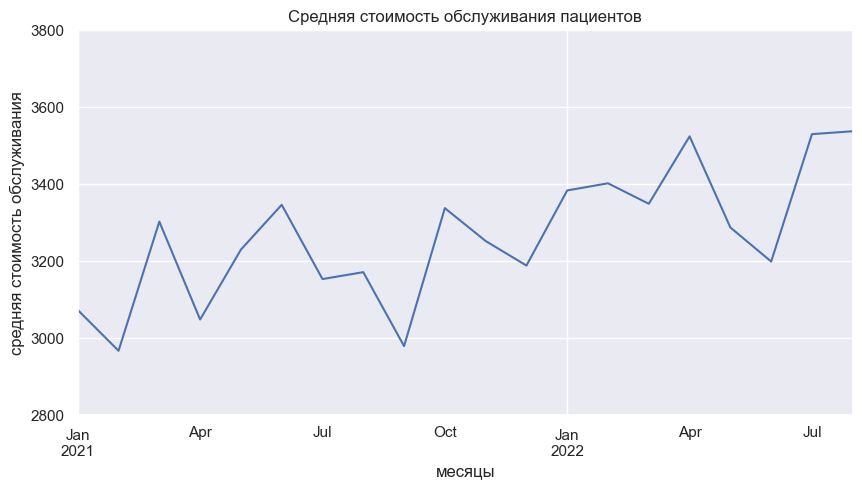

In [42]:
# построим график зависимости Средней стоимости обслуживания пациентов от времени по месяцам
fig, ax = plt.subplots(figsize=(10, 5))
average_cost_of_service.resample('M').mean().plot(ylim=(2800, 3800), grid=True)
ax.set(title = 'Средняя стоимость обслуживания пациентов',
       xlabel = 'месяцы', ylabel = 'средняя стоимость обслуживания');

In [43]:
# средняя стоимость обслуживания пациентов в 2021 (январь-август)
average_cost_of_service['2021-01' : '2021-08'].mean()

3163.9060326119175

In [44]:
# средняя стоимость обслуживания пациентов в 2021 (январь-август)
average_cost_of_service['2022-01' : '2022-08'].mean()

3402.2814843195642

In [45]:
# Увеличение средней стоимости обслуживания год к году (за 8 месяцев) в процентах
(average_cost_of_service['2022-01' : '2022-08'].mean() / average_cost_of_service['2021-01' : '2021-08'].mean() - 1) * 100

7.534214014278406

Попытаемся понять, с чем может быть связано увеличение средней стоимости обслуживания.
Это может быть:
- изменение цены услуг
- изменение интенсивности лечения пациентов (т.е. пациенты стали получать больше услуг за 1 визит)
- изменение половозрастной структуры
- изменение структуры спроса

### Изменение цены услуг

Гипотеза № 1: увеличение стоимости обслуживания связано с увеличением цен на услуги.

In [46]:
# найдем изменение средней цены услуг как отношение выручки к количеству услуг за период
# количество услуг за период считаем по количеству платежей (1 услуга = 1 платеж)
average_price_of_services = df.groupby('year_month')['service_amount'].sum() / df.groupby('year_month')['service_amount'].count()
average_price_of_services.head()

year_month
2021-01    1121.192974
2021-02    1122.228774
2021-03    1062.567100
2021-04    1132.201344
2021-05    1134.893875
Freq: M, Name: service_amount, dtype: float64

In [47]:
# изменение cредней цены услуг год к году (за 8 месяцев) в процентах
(average_price_of_services['2022-01' : '2022-08'].mean() / average_price_of_services['2021-01' : '2021-08'].mean() - 1) * 100

6.836036867965323

In [48]:
# средняя цена услуг в 2021 (январь - август)
average_price_of_services['2021-01' : '2021-08'].mean()

1120.056239686417

In [49]:
# средняя цена услуг в 2022 (январь - август)
average_price_of_services['2022-01' : '2022-08'].mean()

1196.6236971733265

Средняя цена оказанных услуг выросла год к году на 6,8%. Но это косвенный показатель, он еще не доказывает, что изменились цены услуг в прайс-листе.

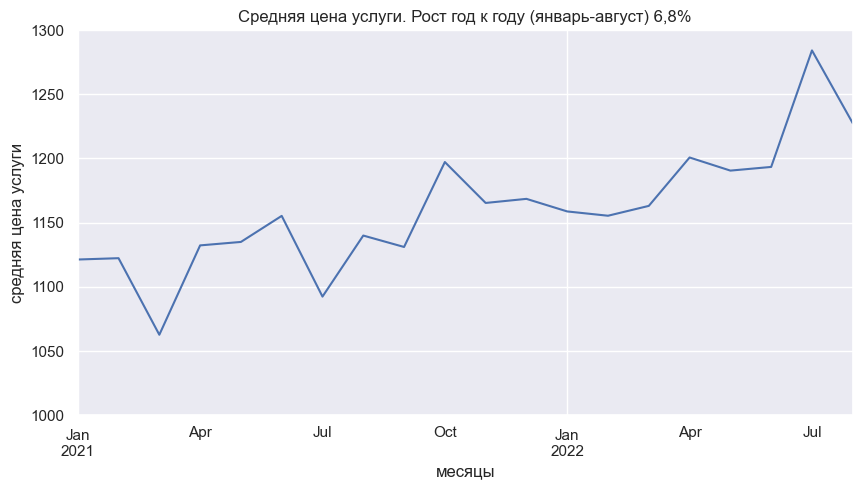

In [50]:
# построим график зависимости Средней цены услуги от времени по месяцам
fig, ax = plt.subplots(figsize=(10, 5))
average_price_of_services.resample('M').mean().plot(ylim=(1000, 1300), grid=True)
ax.set(title = 'Средняя цена услуги. Рост год к году (январь-август) 6,8%',
       xlabel = 'месяцы', ylabel = 'средняя цена услуги');

Посмотрим как изменилась цена услуг в прайс-листе. Для этого выделим отдельно услуги, которые были на протяжении всего периода, в 2021 году и в 2022, затем найдем величину изменения цены.

In [51]:
# перечень услуг в 2021 году (январь - август)
service_2021 = df.query('year_month >= "2021-01" and year_month <= "2021-08"')['service_name']\
.sort_values().unique()

In [52]:
# перечень услуг в 2022 году (январь - август)
service_2022 = df.query('year_month >= "2022-01" and year_month <= "2022-08"')['service_name']\
.sort_values().unique()

In [53]:
# количество уникальных услуг в 2021 (январь-август)
len(service_2021)

596

In [54]:
# количество уникальных услуг в 2022 (январь-август)
len(service_2022)

679

In [55]:
# уникальные услуги в 2021 и в 2022 годах (январь-август), пересечение
service_2021_2022 = set(service_2021).intersection(service_2022)

In [56]:
# количество уникальных услуг в 2021 и в 2022 годах (январь-август)
len(service_2021_2022)

439

In [57]:
# средняя цена 439 услуг в 2021 году
df.query('year_month >= "2021-01" and year_month <= "2021-08" and service_name in @service_2021_2022')['service_amount'].mean()

950.5417384315076

In [58]:
# средняя цена 439 услуг в 2022 году
df.query('year_month >= "2022-01" and year_month <= "2022-08" and service_name in @service_2021_2022')['service_amount'].mean()

1037.987041766827

In [59]:
# рост цены услуг год к году в процентах
(
df.query('year_month >= "2022-01" and year_month <= "2022-08" and service_name in @service_2021_2022')['service_amount'].mean()
/
df.query('year_month >= "2021-01" and year_month <= "2021-08" and service_name in @service_2021_2022')['service_amount'].mean()
- 1
) * 100

9.199522735278642

Цена на совпадающие услуги (это большинство услуг, 74% от услуг 2021 года и 65% от услуг 2022 года) выросла год к году на 9,2%.

In [60]:
# найдем изменение средней цены совпадающих 439 услуг по месяцам
average_price_of_services_439 = df.query('service_name in @service_2021_2022')\
.groupby('year_month')['service_amount'].sum() / df.query('service_name in @service_2021_2022')\
.groupby('year_month')['service_amount'].count()
average_price_of_services_439.head()

year_month
2021-01    967.387072
2021-02    929.721249
2021-03    867.665456
2021-04    983.272289
2021-05    983.707816
Freq: M, Name: service_amount, dtype: float64

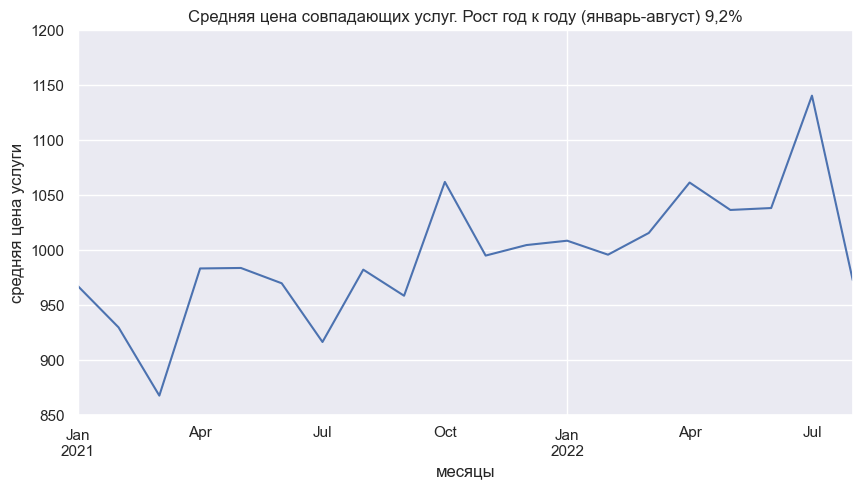

In [61]:
# построим график зависимости Средней цены услуги от времени по месяцам
fig, ax = plt.subplots(figsize=(10, 5))
average_price_of_services_439.plot(ylim=(850, 1200), grid=True)
ax.set(title = 'Средняя цена совпадающих услуг. Рост год к году (январь-август) 9,2%',
       xlabel = 'месяцы', ylabel = 'средняя цена услуги');

Средняя цена совпадающих 439 услуг в 2021 году и в 2022 году зависит от структуры выбранных услуг и ещё не доказывает впрямую, что выросла прайсовая цена услуг. Например средняя цена услуг в 2022 году могла вырасти теоретически от того, что клиенты выбрали более дорогие услуги (далее будет показано, что этого в самом деле не происходило). А сейчас можно уйти от влияния структуры услуг просто проссумировав среднюю цену этих 439 услуг и 2021 году и 2022 году.

In [62]:
# получим перечень 439 услуг со средней ценой за период январь - август 2021
df.query('service_name in @service_2021_2022 and year_month >= "2021-01" and year_month <= "2021-08"')\
[['service_name', 'service_amount']].groupby('service_name').mean().reset_index().head()

,service_name,service_amount
0,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",1449.0
1,25-oh витамин d (25-гидроксихолекальциферол),3255.0
2,chlamydia pneumoniae igg,599.0
3,chlamydia pneumoniae igm,599.0
4,chlamydia trachomatis (соскоб),378.0


In [63]:
# посчитаем средний прайс на 439 общих услуг за период январь - август 2021
df.query('service_name in @service_2021_2022 and year_month >= "2021-01" and year_month <= "2021-08"')\
[['service_name', 'service_amount']].groupby('service_name').mean().reset_index()['service_amount'].mean()

1283.9893059052042

In [64]:
# посчитаем средний прайс на 439 общих услуг за период январь - август 2022
df.query('service_name in @service_2021_2022 and year_month >= "2022-01" and year_month <= "2022-08"')\
[['service_name', 'service_amount']].groupby('service_name').mean().reset_index()['service_amount'].mean()

1350.1647621297582

In [65]:
# рост средней цены прайса с 2021 по 2022 год на 439 услуг в процентах
(df.query('service_name in @service_2021_2022 and year_month >= "2022-01" and year_month <= "2022-08"')\
[['service_name', 'service_amount']].groupby('service_name').mean().reset_index()['service_amount'].mean() /
df.query('service_name in @service_2021_2022 and year_month >= "2021-01" and year_month <= "2021-08"')\
[['service_name', 'service_amount']].groupby('service_name').mean().reset_index()['service_amount'].mean() - 1) * 100

5.153894656303293

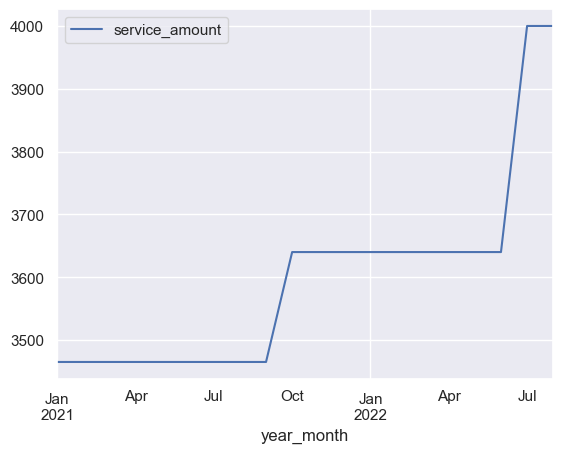

In [66]:
# пример роста цены на услугу "эхокардиография с допплеровским анализом"
df.query('service_name == "эхокардиография с допплеровским анализом"')[['service_amount', 'year_month']]\
.plot(x='year_month', y='service_amount');

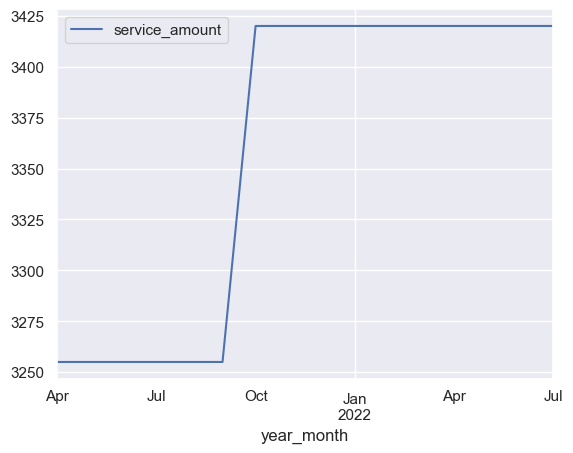

In [67]:
# пример роста цены на услугу "25-oh витамин d (25-гидроксихолекальциферол)"
df.query('service_name == "25-oh витамин d (25-гидроксихолекальциферол)"')[['service_amount', 'year_month']]\
.plot(x='year_month', y='service_amount');

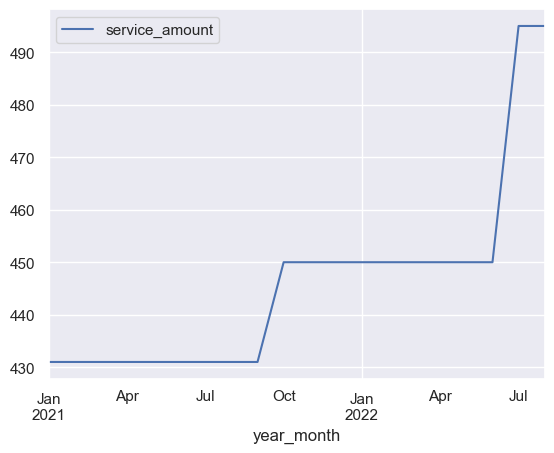

In [68]:
# пример роста цены на услугу "анализ мочи по Нечипоренко"
df.query('service_name == "анализ мочи по нечипоренко"')[['service_amount', 'year_month']]\
.plot(x='year_month', y='service_amount');

In [69]:
# пример роста цен на отдельные услуги. Видно, что повышение цен  было в октябре 2021 и июле 2022
services_439 = df.query('service_name in @service_2021_2022')[['service_name', 'service_amount', 'year_month']]\
.groupby(['service_name', 'year_month'])['service_amount'].mean().reset_index()
services_439.head(60)

,service_name,year_month,service_amount
0,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2021-07,1449.0
1,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2021-09,1449.0
2,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2021-10,1520.0
3,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2022-02,1520.0
4,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2022-03,1520.0
5,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2022-04,1520.0
6,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2022-05,1520.0
7,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",2022-07,1520.0
8,25-oh витамин d (25-гидроксихолекальциферол),2021-04,3255.0
9,25-oh витамин d (25-гидроксихолекальциферол),2021-05,3255.0


Для того, чтобы показать повышение цен услуг более наглядно, найдём цены услуг, когда они впервые упоминаются в 2021 году и когда они (эти же услуги) в последний раз упоминаются в 2022 году.

In [70]:
# цены 439 услуг, которые впервые упоминаются в 2021 году
services_439_2021 = services_439.query('year_month <= "2021-12"').groupby('service_name')['service_amount'].agg('first').reset_index()
services_439_2021.columns = ['service_name', 'service_amount_21']
services_439_2021

,service_name,service_amount_21
0,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",1449.0
1,25-oh витамин d (25-гидроксихолекальциферол),3255.0
2,chlamydia pneumoniae igg,599.0
3,chlamydia pneumoniae igm,599.0
4,chlamydia trachomatis (соскоб),378.0
...,...,...
434,эпителий морской свинки,1155.0
435,эпителий мыши,1155.0
436,эпителий собаки,1155.0
437,эстрадиол,630.0


In [71]:
# цены 439 услуг, которые в последний раз упоминаются в 2022 году
services_439_2022 = services_439.query('year_month >= "2022-01"').groupby('service_name')['service_amount'].agg('last').reset_index()
services_439_2022.columns = ['service_name', 'service_amount_22']
services_439_2022

,service_name,service_amount_22
0,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",1520.0
1,25-oh витамин d (25-гидроксихолекальциферол),3420.0
2,chlamydia pneumoniae igg,690.0
3,chlamydia pneumoniae igm,690.0
4,chlamydia trachomatis (соскоб),400.0
...,...,...
434,эпителий морской свинки,1210.0
435,эпителий мыши,1210.0
436,эпителий собаки,1210.0
437,эстрадиол,700.0


In [72]:
# объединим полученные выше таблицы
services_439_2021_vs_2022 = services_439_2021.merge(services_439_2022)
services_439_2021_vs_2022.head()

,service_name,service_amount_21,service_amount_22
0,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",1449.0,1520.0
1,25-oh витамин d (25-гидроксихолекальциферол),3255.0,3420.0
2,chlamydia pneumoniae igg,599.0,690.0
3,chlamydia pneumoniae igm,599.0,690.0
4,chlamydia trachomatis (соскоб),378.0,400.0


In [73]:
# добавим столбец - рост цен в процентах
services_439_2021_vs_2022['growth_percent'] = (services_439_2021_vs_2022['service_amount_22'] /
services_439_2021_vs_2022['service_amount_21'] -1) * 100

In [74]:
services_439_2021_vs_2022.head()

,service_name,service_amount_21,service_amount_22,growth_percent
0,"(б1 (11))аллергопанель ige шерсть кошки, шерст...",1449.0,1520.0,4.899931
1,25-oh витамин d (25-гидроксихолекальциферол),3255.0,3420.0,5.069124
2,chlamydia pneumoniae igg,599.0,690.0,15.191987
3,chlamydia pneumoniae igm,599.0,690.0,15.191987
4,chlamydia trachomatis (соскоб),378.0,400.0,5.820106


In [75]:
# найдём средний рост в процентах
services_439_2021_vs_2022['growth_percent'].mean()

10.18551772375128

In [76]:
# найдём средневзвешенный рост в процентах
(services_439_2021_vs_2022['service_amount_22'].sum() / services_439_2021_vs_2022['service_amount_21'].sum() - 1) * 100

9.24074347295447

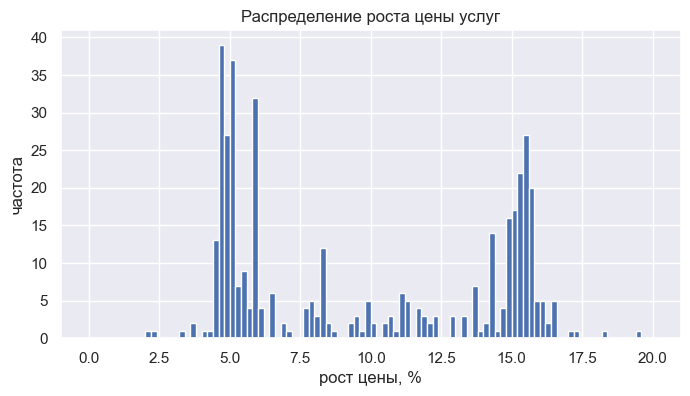

In [77]:
# распределение роста цены услуг
fig, ax = plt.subplots(figsize=(8, 4))
ax.set(title = 'Распределение роста цены услуг',
       xlabel = 'рост цены, %', ylabel = 'частота');
services_439_2021_vs_2022['growth_percent'].hist(bins=100, range=(0, 20));

Видим 2 пика: 5% и 15%. В первый пик попали услуги, которые подорожали 1 раз (первое повышение цен было на 5%). Во второй пик попали услуги, которые подорожали два раза (первый раз в октябре 2021 года на 5%, а второе повышение цен в июле 2022 года было на 10%).

Посмотрим, какие услуги подорожали и подешевели максимально.

In [78]:
services_439_2021_vs_2022['growth_percent'].min()

-47.47474747474747

In [79]:
services_439_2021_vs_2022['growth_percent'].max()

134.22053231939165

In [80]:
# услуги, которые максимально подешевели
services_439_2021_vs_2022[services_439_2021_vs_2022['growth_percent'] < -30].sort_values(by='growth_percent')

,service_name,service_amount_21,service_amount_22,growth_percent
344,"сеанс sis терапии, длинный цикл, 1 зона",6930.0,3640.0,-47.474747
425,электронейромиография - игольчатая миография в...,7560.0,3975.0,-47.420635
293,промывание слезных путей (один глаз),1156.0,610.0,-47.231834
300,пункция с введением лекарственного средства (б...,4390.0,2530.0,-42.369021
244,плановое гистологическое исследование материал...,4332.0,3030.0,-30.055402


In [81]:
# услуги, которые максимально подорожали
services_439_2021_vs_2022[services_439_2021_vs_2022['growth_percent'] > 30].sort_values(by='growth_percent')

,service_name,service_amount_21,service_amount_22,growth_percent
278,постановка кожных аллергопроб (за 1 единицу),2772.0,3640.000000,31.313131
153,исследование отделяемого молочной железы,887.0,1250.000000,40.924464
145,инфильтрационная анестезия (малых объемов),1019.0,1475.000000,44.749755
401,ультразвуковое исследование сустава,1890.0,2802.857143,48.299320
216,мрт коленного сустава,6195.0,9750.000000,57.384988
109,гистологическое исследование операционного мат...,2426.0,3825.000000,57.666941
90,"взятие материала на посев, цитологическое иссл...",284.0,495.000000,74.295775
372,туалет слухового прохода,515.0,1180.000000,129.126214
96,вскрытие абсцедирующего фурункула,4851.0,11200.000000,130.880231
85,введение лекарственных препаратов в наружный с...,263.0,616.000000,134.220532


Дополнительно можно посмотреть как отличается средняя цена не совпадающих услуг в 2021 и 2022 годах.

In [82]:
# средняя цена услуг в 2021 году, которых нет в 2022 году
df.query('year_month >= "2021-01" and year_month <= "2021-08" and service_name not in @service_2021_2022')['service_amount'].mean()

1438.185876797596

In [83]:
# средняя цена услуг в 2022 году, которых нет в 2021 году
df.query('year_month >= "2022-01" and year_month <= "2022-08" and service_name not in @service_2021_2022')['service_amount'].mean()

1487.5841287535707

In [84]:
# разница в  ценах несовпадающих услуг год к году в процентах
(
df.query('year_month >= "2022-01" and year_month <= "2022-08" and service_name not in @service_2021_2022')['service_amount'].mean()
/
df.query('year_month >= "2021-01" and year_month <= "2021-08" and service_name not in @service_2021_2022')['service_amount'].mean()
- 1
) * 100

3.4347613026189494

Средняя цена несовпадающих услуг в 2022 году на 3,4% выше, чем 2021

**Выводы:**

Гипотеза о том, что увеличение средней стоимости обслуживания связано с увеличением цен на услуги, подтверждается.

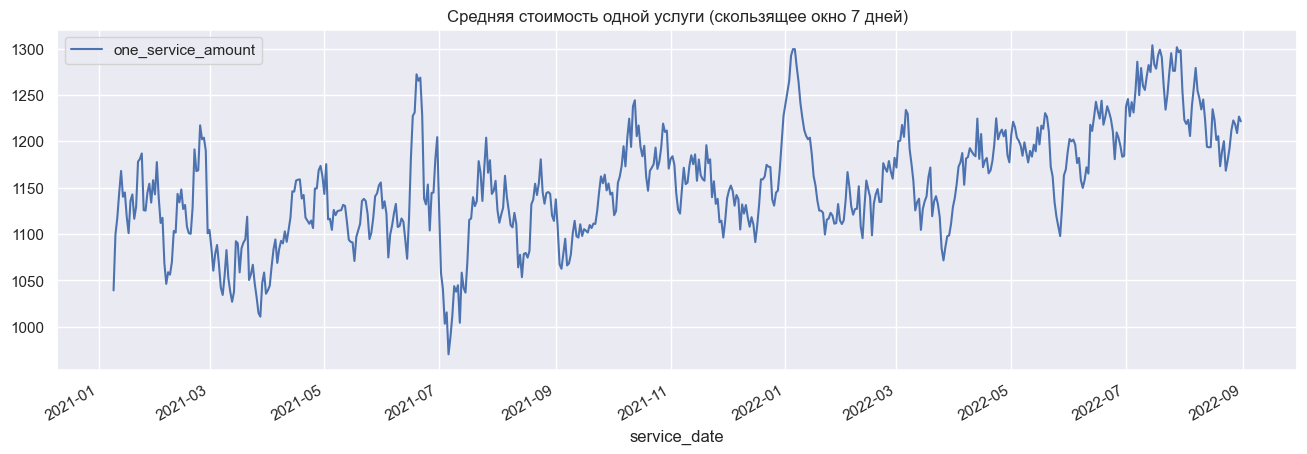

In [85]:
# средняя цена одной услуги по времени 
(df
 .assign(one_service_amount = lambda x: x['service_amount']/x['service_number'])
 .pivot_table(index='service_date', values='one_service_amount', aggfunc='mean')
).rolling(7).mean().plot(figsize=(16,5), grid=True, title='Средняя стоимость одной услуги (скользящее окно 7 дней)');

### Изменение интенсивности лечения

Гипотеза № 2: увеличение средней стоимости обслуживания связано у увеличением интенсивности лечения (т.е. за один визит пациенты стали получать большее количество услуг)

In [86]:
# количество услуг в месяц (1 платеж = 1 услуга)
services_month = df.groupby('year_month')['service_amount'].count()
services_month.head()

year_month
2021-01    2021
2021-02    2120
2021-03    3696
2021-04    3869
2021-05    3788
Freq: M, Name: service_amount, dtype: int64

In [87]:
# количество визитов в месяц
visits_month.head()

year_month
2021-01     743
2021-02     803
2021-03    1180
2021-04    1423
2021-05    1329
Freq: M, Name: insured, dtype: int64

In [88]:
# среднее количество услуг на 1 визит
average_number_of_services_per_visit = services_month / visits_month
average_number_of_services_per_visit

year_month
2021-01    2.720054
2021-02    2.640100
2021-03    3.132203
2021-04    2.718904
2021-05    2.850263
2021-06    2.919463
2021-07    2.891517
2021-08    2.776799
2021-09    2.639825
2021-10    2.778387
2021-11    2.777096
2021-12    2.746957
2022-01    2.932059
2022-02    2.956802
2022-03    2.889063
2022-04    2.927384
2022-05    2.758113
2022-06    2.675174
2022-07    2.761552
2022-08    2.898565
Freq: M, dtype: float64

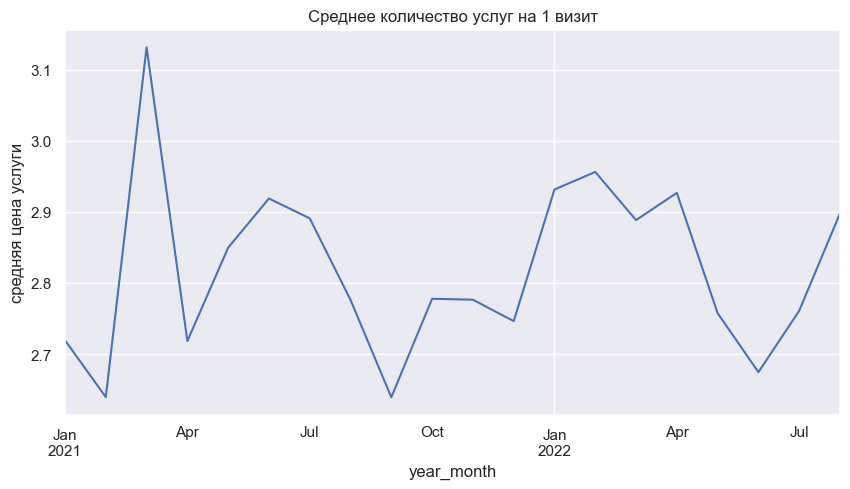

In [89]:
# построим график зависимости среднего количества услуг на 1 визит от времени по месяцам
fig, ax = plt.subplots(figsize=(10, 5))
ax.set(title = 'Среднее количество услуг на 1 визит',
       xlabel = 'месяцы', ylabel = 'средняя цена услуги');
average_number_of_services_per_visit.plot(grid=True);

In [90]:
# среднее количество услуг на 1 визит январь - август 2021
average_number_of_services_per_visit['2021-01-31': '2021-08-31'].mean()

2.8311628717305433

In [91]:
# среднее количество услуг на 1 визит январь - август 2022
average_number_of_services_per_visit['2022-01-31': '2022-08-31'].mean()

2.849838961500061

In [92]:
# изменение среднего количества услуг на 1 визит год к году в процентах
(average_number_of_services_per_visit['2022-01-31': '2022-08-31'].mean() /
average_number_of_services_per_visit['2021-01-31': '2021-08-31'].mean() - 1) * 100

0.6596614400393719

Среднее количество услуг на одного клиента в 2021 15.813040969417196
Среднее количество услуг на одного клиента в 2022 15.171563293434893


Ttest_indResult(statistic=1.104637471452569, pvalue=0.26937592501162944)

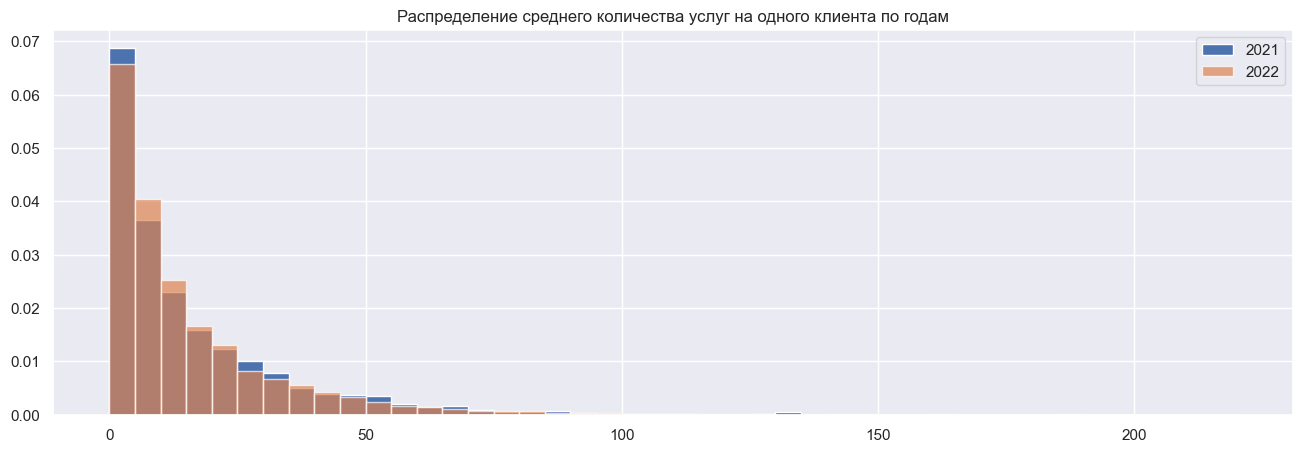

In [93]:
# считаем среднее количество услуг на одного клиента по годам (за 8 месяцев 2021 и 2022 года):
tmp_2021 = df.query('year_month <= "2021-08"').groupby('insured').agg({'service_number':'sum'}).reset_index()
tmp_2022 = df.query('year_month >= "2022-01"').groupby('insured').agg({'service_number':'sum'}).reset_index()

# визуализируем результаты:
tmp_2021.service_number.hist(bins=range(0, tmp_2021.service_number.max(), 5), figsize=(16,5), label='2021', density=True)
tmp_2022.service_number.hist(bins=range(0, tmp_2022.service_number.max(), 5), figsize=(16,5), label='2022', alpha=0.7, density=True)
plt.legend()
plt.title('Распределение среднего количества услуг на одного клиента по годам')

# Проводим стат тест:
print('Среднее количество услуг на одного клиента в 2021', tmp_2021.service_number.mean())
print('Среднее количество услуг на одного клиента в 2022', tmp_2022.service_number.mean())

from scipy import stats as st
st.ttest_ind(tmp_2021.service_number, tmp_2022.service_number)

Стат тест показывает, что среднее количество услуг на пациента в 2021 и 2022 году не имеют статистически значимых отличий.

**Выводы:**

Гипотеза № 2 не подтверждается

### Изменение половозрастной структуры

Гипотеза № 3: изменение стоимости лечения связано с изменением половозрастной структуры

#### Изменение половой структура пациентов

In [94]:
# среднее значение sex_id в 2021 году
df.query('year_month >= "2021-01" and year_month <= "2021-08"')['sex_id'].mean()

1.61951967679186

In [95]:
# среднее значение sex_id в 2022 году
df.query('year_month >= "2022-01" and year_month <= "2022-08"')['sex_id'].mean()

1.6294994753154208

In [96]:
# изменение среднего значения sex_id (половой структуры) год к году в процентах
(df.query('year_month >= "2022-01" and year_month <= "2022-08"')['sex_id'].mean() /
 df.query('year_month >= "2021-01" and year_month <= "2021-08"')['sex_id'].mean() -1) * 100

0.6162196524422514

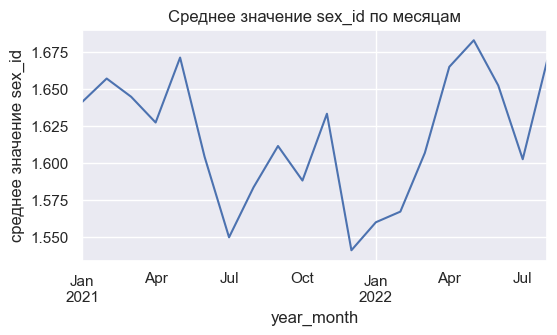

In [97]:
# График изменения среднего значения sex_id по месяцам
fig, ax = plt.subplots(figsize=(6, 3))
ax.set(title = 'Среднее значение sex_id по месяцам', xlabel = 'месяцы', ylabel = 'среднее значение sex_id');
df.groupby('year_month')['sex_id'].mean().plot();

Влияние половой структуры пациентов на среднюю стоимость лечения не подтверждается.

#### Изменение возрастной структуры пациентов

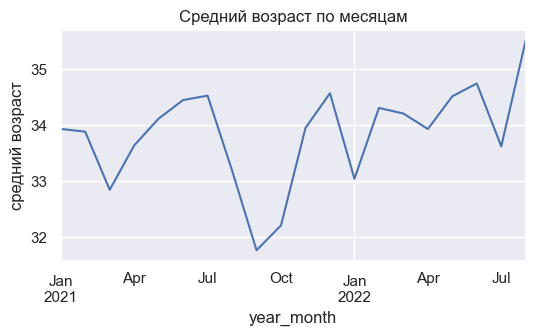

In [98]:
# График изменения среднего возраста по месяцам
fig, ax = plt.subplots(figsize=(6, 3))
ax.set(title = 'Средний возраст по месяцам', xlabel = 'месяцы', ylabel = 'средний возраст')
df.groupby('year_month')['age_for_service_date'].mean().plot();

In [99]:
# изменение среднего возраста год к году в процентах
(df.query('year_month >= "2022-01" and year_month <= "2022-08"')['age_for_service_date'].mean() /
 df.query('year_month >= "2021-01" and year_month <= "2021-08"')['age_for_service_date'].mean() -1) * 100

1.1706002829534157

Изменение среднего возраста пациентов не имеет выраженной тенденции и по величине незначительно (изменения происходят скорее всего в силу случайности). Влияние возрастной структуры пациентов на среднюю стоимость лечения не подтверждается.

**Выводы:**

Гипотеза № 3 не подтверждается

### Изменение структуры услуг

Гипотеза № 4: изменение средней стоимости обслуживания связано с изменением структуры услуг (пациенты стали потреблять другие  более дорогие услуги)

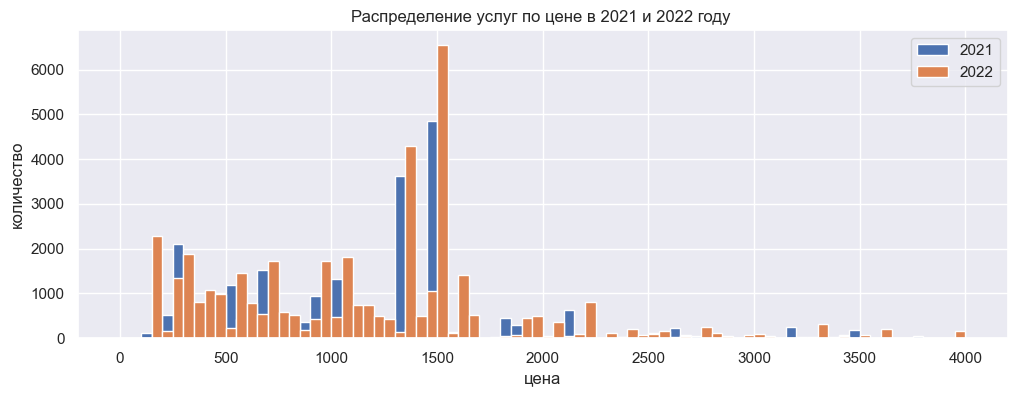

In [100]:
# построим распределение услуг по цене в 2021 и 2022 годах
fig, ax = plt.subplots(figsize=(12, 4))
df.query('year_month >= "2021-01" and year_month <= "2021-08"')['service_amount'].hist(bins=80, range=(0, 4000), label='2021')
df.query('year_month >= "2022-01" and year_month <= "2022-08"')['service_amount'].hist(bins=80, range=(0, 4000), label='2022')
plt.legend()
ax.set(title = 'Распределение услуг по цене в 2021 и 2022 году ', xlabel = 'цена', ylabel = 'количество');

На распределениях услуг по цене мы видим, что структура услуг не изменилась (что ожидаемо). На распределениях четко видно, что пики в 2022 году немного сдвинулись вправо, что показывает, что эти же услуги подорожали, но структура их не изменилась. Также видно, что увеличилось количество услуг, что связано с увеличением количества визитов.

**Выводы:**

Гипотеза № 4 не подтверждается

### Выводы:

В процессе исследования мы выполнили следующее.

Загрузили данные и выполнили базовый анализ данных. Базовый анализ позволяет сказать, что данные достаточно полные, дубликатов и аномальных значений не обнаружено.

Провели исследовательский анализ данных, сравнили различные показатели 2021 и 2022 годов. Для корректности сравнения все показатели и метрики брали за январь - август 2021 года и сравнивали с январем - августом 2022 года (сравнение год к году). Получили следующие результаты:

1. Выручка клиники выросла с 2021 год по 2022 год (январь - август) на 63,5%. Выручка в 2022 году (с января по июль) превышала выручку 2021 года по месяцам в пределах от 123% (в феврале) до 52% (в июне). При этом рост выручки замедлялся (от января к июлю), а в августе 2022 года выручка резко упала, что нельзя обьяснить сезонным фактором и/или случайными причинами, и что явно выбивается из динамики выручки и никак не объясняется существующими данными, за исключением одного предположения - в июле 2022 года цены были увеличены на 10%, это могло снизить посещаемость в августе.

2. Увеличение выручки клиники связано с увеличением посещаемости (количества визитов). Выручка увеличилась (год к году за 8 мес) на 63,5%, а количество визитов - на 53,4%. Логчно предположить, что есть еще причины кроме посещаемости, которые привели к увеличению выручки.

3. Средняя стоимость обслуживания выросла год к году на 7,5% (под Ценой лечения или Средней стоимостью обслуживания пациентов будем понимать отношение выручки клиники за период к количеству визитов за этот период (т.е. средний чек клиента или визита).

4. Рассмотрели ключевые драйверы изменения цены лечения и проверили следующие гипотезы:
    - Гипотеза № 1: увеличение стоимости обслуживания связано с увеличением цен на услуги. Увеличение средних цен на всё услуги год к году составило 6,8% , увеличение средних цен на совпадающие услуги (общие для 2021 и 2022 года) год к году составило 5,15%. Определили даты повышения цен на услуги (октябрь 2021 года - примерно на 5% и июль 2022 года - примерно на 10%).Таким образом гипотеза подтверждается.
    - Гипотеза № 2: увеличение средней стоимости обслуживания связано у увеличением интенсивности лечения (т.е. за один визит пациенты стали получать большее количество услуг). Увеличение среднего количества услуг на 1 визит год к году составило 0.66%. Таким образом гипотеза не подтверждается.
    - Гипотеза № 3: изменение стоимости лечения связано с изменением половозрастной структуры. Изменение среднего значения sex_id (половой структуры) год к году в процентах составило 0,6%, а измение среднего возраста составило 1,17%, при этом изменение среднего возраста пациентов не имеет выраженной тенденции (изменения происходят скорее всего в силу случайности). Таким образом гипотеза не подтверждается.
    - Гипотеза № 4: изменение средней стоимости обслуживания связано с изменением структуры услуг (пациенты стали потреблять другие более дорогие услуги). Было показано, что структура услуг по цене не изменилась. Таким образом гипотеза не подтверждается.
    
**Таким образом, ключевой драйвер изменения цены лечения - это повышение цены услуг. Повышение цен услуг происходило дважды: в октябре 2021 года (в среднем на 5%) и в июле 2022 года (в среднем на 10%).**